## Download the CSE-CIC-IDS2018 dataset

In [2]:
# Install AWS CLI (uncomment and run this cell if you haven't installed it yet)
!../venv/bin/pip install awscli --upgrade

import os
import subprocess

# Define the directory path
directory = "../data/CSE-CIC-IDS2018"

# Check if the directory is empty
if not os.listdir(directory):
    # Download data from AWS S3 bucket
    subprocess.run(["aws", "s3", "sync", "--no-sign-request", "--recursive", "s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/", directory], check=True)
    print("Data downloaded successfully.")
else:
    print(f"The directory '{directory}' is not empty. Data download skipped.")


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
The directory '../data/CSE-CIC-IDS2018' is not empty. Data download skipped.


## Data Exploration



In [2]:
! ../venv/bin/pip install pandas pandas scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import os

from lib.helper_functions import *

/tmp/ipykernel_123364/386461427.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [19]:
# if saved dataframe file exists, load
# if dataframe isn't saved, load raw csv file and save the dataframe
dataframe_file = 'data/flowmeter_dataframe.pkl'
exists = os.path.isfile(dataframe_file)
if exists:
    print('dataframe file exists, loading dataframe...')
    df = pd.read_pickle(dataframe_file)
    print('dataframe loaded.')
else:
    directory = 'data/CSE-CIC-IDS2018/'
    df = pd.DataFrame()
    df = read_clean_combine_csv(directory, df, 'Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv')
    # save dataframe to file for future use
    pd.to_pickle(df, dataframe_file)

dataframe file exists, loading dataframe...
dataframe loaded.


In [5]:
df.columns

Index(['dst_port', 'protocol', 'timestamp', 'flow_duration', 'tot_fwd_pkts',
       'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max',
       'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std',
       'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean',
       'bwd_pkt_len_std', 'flow_byts_s', 'flow_pkts_s', 'flow_iat_mean',
       'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot',
       'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min',
       'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
       'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags',
       'bwd_urg_flags', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s',
       'bwd_pkts_s', 'pkt_len_min', 'pkt_len_max', 'pkt_len_mean',
       'pkt_len_std', 'pkt_len_var', 'fin_flag_cnt', 'syn_flag_cnt',
       'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt',
       'cwe_flag_count', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg',
      

In [6]:
df.memory_usage().sum() / 1024**2

2393.8285989761353

In [7]:
len(df)

8284195

In [8]:
df = df.sort_values(by=['timestamp'])

In [9]:
df = df[df['timestamp'] > pd.to_datetime('2018-01-01')]

In [10]:
df.head()

,dst_port,protocol,timestamp,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,...,fwd_seg_size_min,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
2870002,445,6,2018-02-14 01:00:00,842527,6,5,455,338,140,0,...,20,0.0,0.00000,0,0,0.0,0.00,0,0,Benign
2553995,443,6,2018-02-14 01:00:00,111873906,7,3,169,92,46,0,...,20,155665.5,161.92746,155780,155551,55780940.0,3933152.75,58562100,52999782,Benign
2737017,80,6,2018-02-14 01:00:00,624,3,4,161,488,161,0,...,20,0.0,0.00000,0,0,0.0,0.00,0,0,Benign
2737014,80,6,2018-02-14 01:00:00,89,2,0,0,0,0,0,...,20,0.0,0.00000,0,0,0.0,0.00,0,0,Benign
2737015,80,6,2018-02-14 01:00:00,667,3,4,161,488,161,0,...,20,0.0,0.00000,0,0,0.0,0.00,0,0,Benign


In [11]:
# get count of each label
print(df['label'].value_counts())

label
Benign                      6112137
DDOS attack-HOIC             686012
DoS attacks-Hulk             461912
Bot                          286191
FTP-BruteForce               193360
SSH-Bruteforce               187589
Infilteration                161934
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
DDOS attack-LOIC-UDP           1730
Brute Force -Web                611
Brute Force -XSS                230
SQL Injection                    87
Name: count, dtype: int64


In [12]:
# get distribution in of each label
print(df['label'].value_counts()/len(df))

label
Benign                      0.737808
DDOS attack-HOIC            0.082810
DoS attacks-Hulk            0.055758
Bot                         0.034547
FTP-BruteForce              0.023341
SSH-Bruteforce              0.022644
Infilteration               0.019547
DoS attacks-SlowHTTPTest    0.016886
DoS attacks-GoldenEye       0.005011
DoS attacks-Slowloris       0.001327
DDOS attack-LOIC-UDP        0.000209
Brute Force -Web            0.000074
Brute Force -XSS            0.000028
SQL Injection               0.000011
Name: count, dtype: float64


## Downsample the dataset to 100K rows

In [24]:
from sklearn.utils import resample

dataframe_file = '../data/multiclassification_dataset.pkl'
exists = os.path.isfile(dataframe_file)
if exists:
    print('100k dataframe file exists, loading dataframe...')
    df = pd.read_pickle(dataframe_file)
    print('dataframe loaded.')
else:
    # Calculate class counts
    class_counts = df['label'].value_counts().to_dict()

    # Total desired number of instances
    total_instances = 100000

    # Calculate the downsampled number of instances for each class
    downsampled_counts = {}
    for label, count in class_counts.items():
        downsampled_counts[label] = min(count, total_instances // len(class_counts))

    # Downsample each class to the desired number of instances
    downsampled_data = pd.DataFrame()
    for label, count in downsampled_counts.items():
        class_data = df[df['label'] == label]
        downsampled_data = pd.concat([downsampled_data, resample(class_data,
                                                            replace=False,
                                                            n_samples=count,
                                                            random_state=42)])

    # Shuffle the downsampled data
    downsampled_data = downsampled_data.sample(frac=1, random_state=42)

    # Check the total number of instances
    print("Total number of instances after downsampling:", len(downsampled_data))
    # save dataframe to file for future use
    df = downsampled_data.drop(['dst_port', 'protocol', 'timestamp', 'cwe_flag_count'], axis=1)  # Features
    df.sort_index(axis=1, inplace=True)
    print('The totale number of features is:', len(df.columns))
    pd.to_pickle(df, dataframe_file)


100k dataframe file exists, loading dataframe...
dataframe loaded.


In [25]:
df.columns

Index(['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std',
       'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max',
       'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot',
       'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min',
       'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags',
       'bwd_seg_size_avg', 'bwd_urg_flags', 'down_up_ratio', 'ece_flag_cnt',
       'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max',
       'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s',
       'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg',
       'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min',
       'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean',
       'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s',
       'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min',
       'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 

In [26]:
df['label'].value_counts()

label
DoS attacks-Hulk            7142
Bot                         7142
DoS attacks-Slowloris       7142
DDOS attack-HOIC            7142
SSH-Bruteforce              7142
Infilteration               7142
Benign                      7142
DoS attacks-GoldenEye       7142
DoS attacks-SlowHTTPTest    7142
FTP-BruteForce              7142
DDOS attack-LOIC-UDP        1730
Brute Force -Web             611
Brute Force -XSS             230
SQL Injection                 87
Name: count, dtype: int64

## Create the multiclassification model for the threat detection

In [27]:
from sklearn.preprocessing import LabelEncoder

# Encode labels to integers
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df['label'].value_counts()

label
7     7142
1     7142
9     7142
4     7142
13    7142
11    7142
0     7142
6     7142
8     7142
10    7142
5     1730
2      611
3      230
12      87
Name: count, dtype: int64

In [28]:
from sklearn.model_selection import train_test_split

# Assuming you already have your dataset stored in a pandas DataFrame df
# X contains the features and y contains the labels
X = df.drop(['label'], axis=1)  # Features
y = df['label']                # Labels

# Optionally, you can also specify stratification to ensure class balance in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shapes of the train and test sets to verify the split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (59262, 75)
Shape of X_test: (14816, 75)
Shape of y_train: (59262,)
Shape of y_test: (14816,)


### Random Forest Model

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pickle

model_file = '../models/rf_classifier.pkl'

exists = os.path.isfile(model_file)

if exists:
    print('Random Forest model exists, loading model...')
    rf_classifier = pickle.load(open(model_file, 'rb'))
    print('model loaded.')
else:
    print('Random Forest model does not exist, training model...')
    # Create a Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=300, random_state=42)

    # Train the classifier on the training data
    rf_classifier.fit(X_train, y_train)
    print('model trained.')
    # save model to file for future use
    pickle.dump(rf_classifier, open(model_file, 'wb'))

Random Forest model exists, loading model...
model loaded.


#### Model Evaluation

In [ ]:
# Predict on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

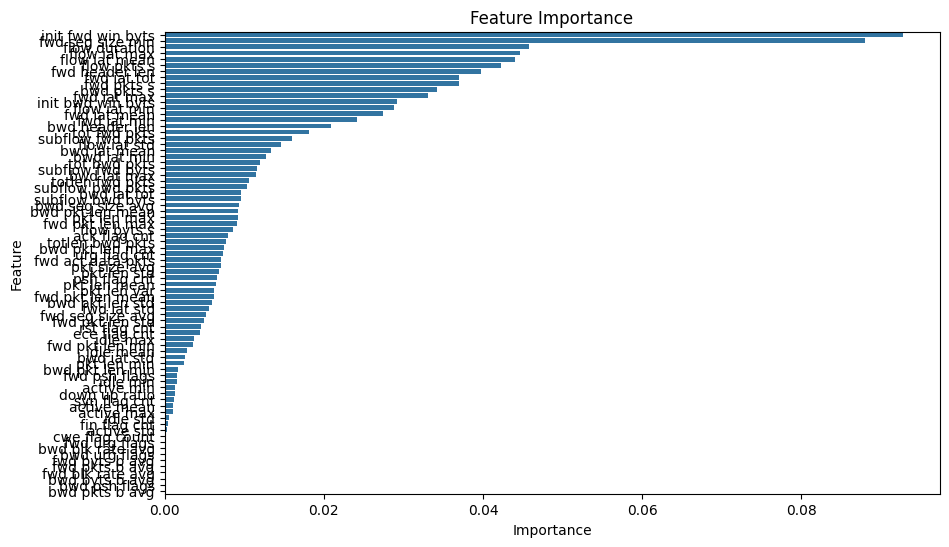

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = rf_classifier.feature_importances_

df_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by feature importance in descending order
df_importance_sorted = df_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_importance_sorted)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


### Neural Networks

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Assuming you have already split your data into X_train, X_test, y_train, y_test

# Define the number of classes
num_classes = len(set(y_train))

input_shape = X_train.shape[1]


model = keras.Sequential([
    keras.layers.Dense(input_shape, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)


Epoch 1/100
1471/1482 [============================>.] - ETA: 0s - loss: 1.9046 - accuracy: 0.3541

### XGBoost Classifier

In [25]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Assuming you have already split your data into X_train, X_test, y_train, y_test
# Assuming num_classes is already defined

# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=num_classes)

# Define hyperparameters grid
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Perform Grid Search Cross Validation
grid_search.fit(X_train, y_train)

# Get best estimator
best_xgb_classifier = grid_search.best_estimator_

# Make predictions
y_pred = best_xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...................learning_rate=0.1, subsample=0.5; total time=  19.1s
[CV] END ...................learning_rate=0.1, subsample=0.5; total time=  19.2s
[CV] END ...................learning_rate=0.1, subsample=0.5; total time=  14.4s
[CV] END ...................learning_rate=0.1, subsample=0.5; total time=  18.1s
[CV] END ...................learning_rate=0.1, subsample=0.5; total time=  14.5s
[CV] END ...................learning_rate=0.1, subsample=0.7; total time=  15.7s
[CV] END ...................learning_rate=0.1, subsample=0.7; total time=  16.5s
[CV] END ...................learning_rate=0.1, subsample=0.7; total time=  15.1s
[CV] END ...................learning_rate=0.1, subsample=0.7; total time=  14.6s
[CV] END ...................learning_rate=0.1, subsample=0.7; total time=  15.3s
[CV] END .....................learning_rate=0.1, subsample=1; total time=  16.4s
[CV] END .....................learning_rate=0.1, 

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Assuming you have already split your data into X_train, X_test, y_train, y_test

# Initialize the Logistic Regression classifier
logistic_regression = LogisticRegression(C=0.001, max_iter=1000, solver='saga', penalty='l1', verbose=1)  # Increase max_iter if needed

# Train the classifier on the training data
logistic_regression.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logistic_regression.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
